# Dimensionality reduction through Linear Discriminant Analysis

Linear discriminant analysis can be stated as a dimensionality reduction task – find a hyperplane such that points from different classes are maximally separated. The latter can be quantified in two principal ways:

* as a signal-to-noise ratio from signal-processing
* as Bayesian factors from statistics

Both formalisations lead to the equivalent maximisation tasks. 
In this tutorial we do not consider technical details of the LDA transformation, rather we give a visual interpretation to it and explore the connections between LDA and PCA. 
Recall that PCA can be viewed as a dimensionality reduction task with a different objective – find a hyperplane such that all points are maximally separated. 
These tasks are weakly connected. A maximal separation between classes cannot bring all points together but at the same time it does not have to spread them apart inside a single class. 

To explore dimensionality reduction through LDA, we need a high-dimensional dataset with labels. 
We will use an image with different textures and colors such that local textures are strongly connected with different colors.
Therefore, if we split the color space into separate clusters, we get the desired labels for the textures.
The correspondence between image points and local textures allows us to map the LDA dimensions back to the pixels and use various color channels to show their values. This makes it possible to interpret what different LDA dimensions characterise.    

Since the color space is inherently three-dimensional, we use the package `ipyvolume` for making three-dimensional plots interactive. Further details about this package can be obtained from

* [Ipyvolume documentation](https://ipyvolume.readthedocs.io/en/latest/)
* [Maarten Breddels, Interactive 3D Visualization in Jupyter, SciPy 2018, Youtube](https://www.youtube.com/watch?v=hOKa8klJPyo)
* [Maarten Breddels, Interactive 3D Visualization in Jupyter, SciPy 2018, Jupyter Notebook](https://github.com/maartenbreddels/talk-ipyvolume-scipy2018/blob/master/ipyvolume-presentation.ipynb)


We use several functions defined in [`common.py`](./common.py) to juggle between different image representations:

* luminocity decomposition
* conversions between the standard RGB image and color space representation 

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn

# Tools for 3D visualisation
import ipyvolume as ipv
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle

# Tools for LDA and PCA
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Tools for clustering
from sklearn.cluster import KMeans

# Standard stuff
from pandas import Series
from pandas import DataFrame
from tqdm import tnrange#, tqdm_notebook
from plotnine import *

# Local imports
from common import *
from convenience import *

## I. Color-based classification of pixels 

We load the image and annotate each pixel with a color class.   

### Initial image

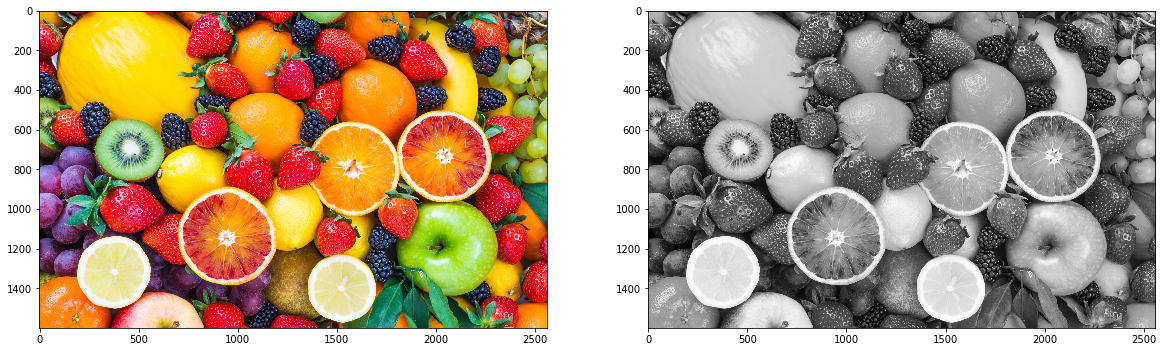

In [2]:
rgb_image = plt.imread('data/texture/colorful_fruits.png')
bw_image = convert_to_grayscale(rgb_image)

fig=plt.figure(figsize=(20,10))
fig.add_subplot(1, 2, 1)
plt.imshow(rgb_image)
fig.add_subplot(1, 2, 2)
plt.imshow(bw_image, cmap='gray')

### Color space representation

In [3]:
full_cs = image_to_colorspace(rgb_image)
sample_cs = image_to_colorspace(rgb_image, sample_count=10000)

In [4]:
show_colorspace(sample_cs, clip=False)

### Luma decomposition

Luma decomposition adds `luma`, `rR`, `rG`, `rB` to the color space so that RGB information is decomposed into luminocity and chroma information. For simplicity the chroma information is stored as a three-dimensional vector `rR`, `rG`, `rB`. The corresponfing formula is

\begin{align*}
RGB = luma \cdot rRGB\,.
\end{align*}

In [5]:
full_cs = luma_decomposition(full_cs)
sample_cs = luma_decomposition(sample_cs)
display(head(full_cs))
show_colorspace(sample_cs[['rR', 'rG', 'rB']].rename(columns = {'rR': 'R', 'rG': 'G', 'rB': 'B'}))

,R,G,B,luma,rR,rG,rB
0,1.000000,0.768627,0.027451,0.753214,1.327644,1.020464,0.036445
1,1.000000,0.760784,0.019608,0.747716,1.337407,1.017478,0.026224
2,0.988235,0.752941,0.000000,0.737360,1.340235,1.021131,0.000000
3,0.976471,0.741176,0.000000,0.726938,1.343266,1.019587,0.000000
4,0.976471,0.749020,0.000000,0.731542,1.334812,1.023892,0.000000


### Color space clustering with k-means algorithm

We will use a relatively small sample to define color clusters and then extend corresponding labelling to the entire set of pixels.

In [6]:
kmeans = KMeans(n_clusters=16).fit(sample_cs[['R', 'G', 'B']])
centers = DataFrame(kmeans.cluster_centers_, columns = ['R', 'G', 'B'])
full_cs = full_cs.assign(label = lambda df: kmeans.predict(df[['R', 'G', 'B']]))[['label', 'R', 'G', 'B', 'luma', 'rR', 'rG', 'rB']]
head(full_cs)

,label,R,G,B,luma,rR,rG,rB
0,14,1.000000,0.768627,0.027451,0.753214,1.327644,1.020464,0.036445
1,14,1.000000,0.760784,0.019608,0.747716,1.337407,1.017478,0.026224
2,14,0.988235,0.752941,0.000000,0.737360,1.340235,1.021131,0.000000
3,14,0.976471,0.741176,0.000000,0.726938,1.343266,1.019587,0.000000
4,14,0.976471,0.749020,0.000000,0.731542,1.334812,1.023892,0.000000


In [7]:
centers

,R,G,B
0,0.929119,0.349218,0.366850
1,0.314567,0.219494,0.317992
2,0.981450,0.795446,0.319093
3,0.953974,0.909163,0.878217
4,0.968695,0.578820,0.032407
5,0.593071,0.090697,0.053801
6,0.193389,0.515302,0.383101
7,0.951158,0.855206,0.630792
8,0.527580,0.460201,0.679098
9,0.873475,0.331001,0.061965


## II. Visual evaluation of clustering quality

* We first compute the mean chroma value for each cluster. 
* Next we transfer color classes to each pixel of a black and white image.
* After that we add the chroma value corresponding to the cluster label to the black and white image.
* As the resulting data structure now has luma-chroma representation we can reconstruct the RGB representation.  

### Chroma values for each color cluster

In [8]:
chromas = (sample_cs
           .assign(label = lambda df: kmeans.predict(df[['R', 'G', 'B']]))
           .groupby('label')
           .aggregate({'rR': np.mean, 'rG': np.mean, 'rB': np.mean})
           .reset_index())

display(chromas)

,label,rR,rG,rB
0,0,1.802557,0.649441,0.701700
1,1,1.223256,0.837243,1.253572
2,2,1.239451,0.994363,0.402081
3,3,1.039612,0.988376,0.956873
4,4,1.536080,0.911603,0.050480
5,5,2.586382,0.341571,0.231828
6,6,0.454009,1.285436,0.962682
7,7,1.112845,0.993506,0.738443
8,8,1.058917,0.900824,1.357070
9,9,1.903365,0.708122,0.135233


Visual comparison of cluster centers and chroma values. For clarity we scale the luminocity of chroma values to maximal intensity.

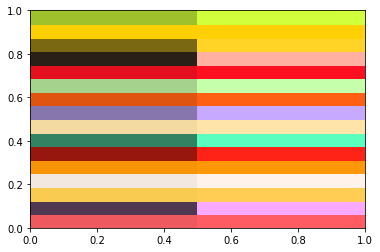

In [9]:
tmp = (chromas[['rR', 'rG', 'rB']]
       .assign(max = lambda df: df.apply(max, axis = 'columns'))
       .assign(rR = lambda df: df['rR']/df['max'])
       .assign(rG = lambda df: df['rG']/df['max'])
       .assign(rB = lambda df: df['rB']/df['max'])
       [['rR', 'rG', 'rB']]
      )

plt.figure()
currentAxis = plt.gca()
n = len(centers)
for i in range(n):
    currentAxis.add_patch(Rectangle((0,   i/n), 0.5, 1/n,alpha=1, color=centers.loc[i,:]))
    currentAxis.add_patch(Rectangle((0.5, i/n), 0.5, 1/n,alpha=1, color=tmp.loc[i,:]))
plt.show()

### Label transfer to black and white image pixels

As we merge the black and white data frame with chroma values we need to store the original order or it would be lost and we would not be able to get the image back.

In [10]:
bw_cspace = (DataFrame(bw_image.flatten(), columns = ['luma'])
             .assign(i = lambda df: df.index.values)
             .assign(label = full_cs['label'])
             [['i', 'label', 'luma']])

head(bw_cspace)

,i,label,luma
0,0,14,0.753214
1,1,14,0.747716
2,2,14,0.737360
3,3,14,0.726938
4,4,14,0.731542


### Chroma transfer to black and white image pixels and image reconstruction

In [11]:
bw_cspace = pd.merge(bw_cspace, chromas, on = 'label').set_index('i').sort_index()
bw_cspace = rgb_reconstruction(bw_cspace)
head(bw_cspace)

,label,luma,rR,rG,rB,R,G,B
i,,,,,,,,
0,14,0.753214,1.282697,1.045954,0.023045,0.966145,0.787827,0.017358
1,14,0.747716,1.282697,1.045954,0.023045,0.959093,0.782076,0.017231
2,14,0.737360,1.282697,1.045954,0.023045,0.945809,0.771244,0.016992
3,14,0.726938,1.282697,1.045954,0.023045,0.932441,0.760343,0.016752
4,14,0.731542,1.282697,1.045954,0.023045,0.938346,0.765159,0.016858


### Visual validation of classification quality 

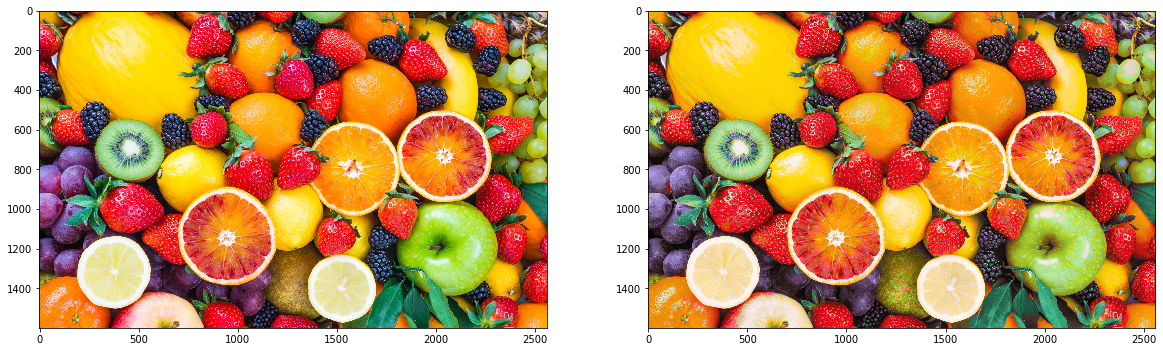

In [12]:
m, n = bw_image.shape
fig=plt.figure(figsize=(20,10))
fig.add_subplot(1, 2, 1)
plt.imshow(rgb_image)
fig.add_subplot(1, 2, 2)
plt.imshow(np.clip(colorspace_to_image(bw_cspace, m, n), 0,1))

## III. Preparations for linear discriminant analysis

Let's first fix the important parameters about the image:
* image size $m\times n$
* texture window size $(2d+1)\times (2d+1)$
* size of the patch grid $k\times \ell$

In [13]:
d = 7
m, n = dim(bw_image)
k = int(m/(2 * d + 1))
l = int(n/(2 * d + 1))

### Grid of labels

Let's arrange the class labels for individual pixels into an $m\times n$ grid for simplicity. 

In [14]:
head(bw_cspace)

,label,luma,rR,rG,rB,R,G,B
i,,,,,,,,
0,14,0.753214,1.282697,1.045954,0.023045,0.966145,0.787827,0.017358
1,14,0.747716,1.282697,1.045954,0.023045,0.959093,0.782076,0.017231
2,14,0.737360,1.282697,1.045954,0.023045,0.945809,0.771244,0.016992
3,14,0.726938,1.282697,1.045954,0.023045,0.932441,0.760343,0.016752
4,14,0.731542,1.282697,1.045954,0.023045,0.938346,0.765159,0.016858


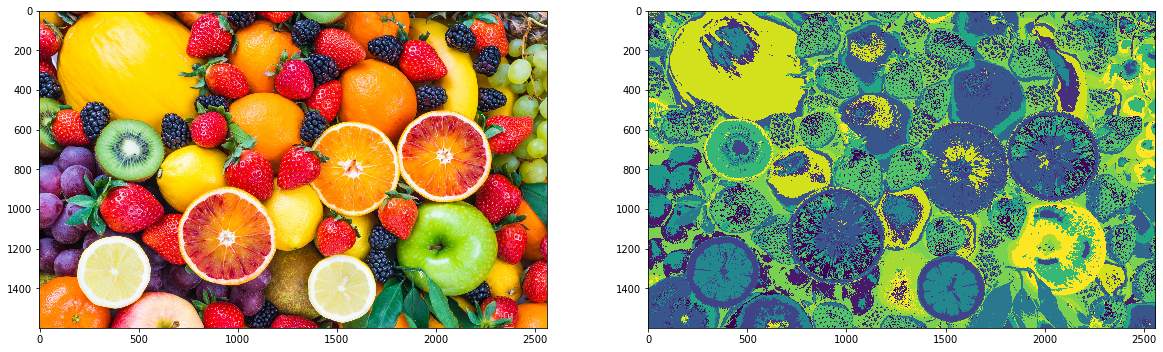

In [15]:
label_grid = bw_cspace['label'].values.reshape(m, n)

fig=plt.figure(figsize=(20,10))
fig.add_subplot(1, 2, 1)
plt.imshow(rgb_image)
fig.add_subplot(1, 2, 2)
plt.imshow(label_grid)

### Extraction of texture windows with corresponding labels

For every coordinate $(x,y)$ we extract a $(2d+1)\times(2d+1)$ window centered in $(x,y)$ and having the label `label_grid[x,y]`.
For simplicity, we ignore all coordinates where one of the following conditions is satisfied:

\begin{align*}
&\begin{aligned}
x&< d\,,\\
x&\geq m-d\,,
\end{aligned}
&
&\begin{aligned}
y&< d\,,\\
y&\geq n-d\,.
\end{aligned}
\end{align*}


In [16]:
def extract_texture_vectors(bw_image: np.array, label_grid: np.array, x: np.array, y:np.array, m: int, n: int, d: int) -> DataFrame:
    
    index = (d <= x) & (x < m - d) & (d <= y) & (y < n - d)
    xm = x[index]
    ym = y[index]
    
    x0 = xm - d
    x1 = xm + d + 1
    y0 = ym - d
    y1 = ym + d + 1
    
    r = len(xm)
    texture_labels = np.empty([r])
    textures = np.empty([r, (2 * d + 1)**2])
    for i in range(r):
        texture_labels[i] = label_grid[xm[i], ym[i]]
        textures[i, :] = bw_image[x0[i]:x1[i], y0[i]:y1[i]].flatten()
        
    columns = ['x{:02d}'.format(i+1) for i in range((2*d+1)**2)]   
    return (DataFrame(textures, columns = columns)
            .assign(label = Series(texture_labels).astype(int))
            .assign(xm = Series(xm).astype(int))
            .assign(ym = Series(ym).astype(int))
            [['label', 'xm', 'ym'] + columns])

Simple test that the function works as expected.

In [17]:
d1 = 1
x =np.array([0,7,8, 1595])
y = x 
index = (d1 <= x) & (x < m - d1) & (d1 <= y) & (y < n - d1)
tmp = extract_texture_vectors(bw_image, label_grid, x, y, m, n , d=d1)
mdisplay([DataFrame(label_grid[x[index],y[index]], columns=['label']), tmp, DataFrame(bw_image[x[index], y[index]], columns = ['luma'])], ['labels', 'textures', 'midpoints'])

labels textures midpoints 
 
 
 label 
 
 
 
 
 14 
 
 
 14 
 
 
 12 
 
 
 
 
 
 label 
 xm 
 ym 
 x01 
 x02 
 x03 
 x04 
 x05 
 x06 
 x07 
 x08 
 x09 
 
 
 
 
 14 
 7 
 7 
 0.744073 
 0.737402 
 0.737402 
 0.744073 
 0.741324 
 0.744073 
 0.725850 
 0.722376 
 0.725850 
 
 
 14 
 8 
 8 
 0.741324 
 0.744073 
 0.739916 
 0.722376 
 0.725850 
 0.734140 
 0.726297 
 0.726297 
 0.730708 
 
 
 12 
 1595 
 1595 
 0.295183 
 0.295183 
 0.293775 
 0.299104 
 0.289854 
 0.286827 
 0.291262 
 0.274169 
 0.267221 
 
 
 
 
 
 luma 
 
 
 
 
 0.741324 
 
 
 0.725850 
 
 
 0.289854

The actual extraction of random texture windows. With small probability returns replicas of the same window. 

In [18]:
d = 7
r = 5000
x = np.random.choice(range(d, m - d), size=r, replace = True)
y = np.random.choice(range(d, n - d), size=r, replace = True)
df = extract_texture_vectors(bw_image, label_grid, x, y, m, n , d)
head(df)

,label,xm,ym,x01,x02,x03,x04,x05,x06,x07,...,x216,x217,x218,x219,x220,x221,x222,x223,x224,x225
0,12,245,1247,0.419616,0.348183,0.330516,0.322995,0.266968,0.259126,0.260256,...,0.396344,0.585775,0.552146,0.407739,0.349858,0.356335,0.340650,0.266383,0.258735,0.317172
1,9,1283,953,0.596035,0.581311,0.555996,0.545429,0.509547,0.529110,0.532687,...,0.478033,0.458234,0.486896,0.451648,0.431191,0.525299,0.529558,0.478407,0.510115,0.409681
2,13,794,2405,0.463921,0.447107,0.439778,0.455505,0.461897,0.457976,0.459384,...,0.348070,0.334240,0.325437,0.309450,0.283209,0.201154,0.129926,0.059145,0.038469,0.042559
3,4,399,1554,0.581038,0.580144,0.578525,0.581999,0.591249,0.602759,0.607363,...,0.605018,0.608493,0.611967,0.611967,0.606638,0.606638,0.606638,0.606638,0.614716,0.617465
4,11,1209,596,0.270640,0.252140,0.225670,0.216849,0.310939,0.455044,0.533104,...,0.255623,0.187706,0.190117,0.269629,0.288510,0.230907,0.239560,0.238388,0.238986,0.234811


## IV. Linear discriminant analysis

Now that we have extracted the texture vectors with their locations and labels, we can use `sklearn` to do linear discriminant analysis. 

In [19]:
head(df.iloc[:, 3:])

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10,...,x216,x217,x218,x219,x220,x221,x222,x223,x224,x225
0,0.419616,0.348183,0.330516,0.322995,0.266968,0.259126,0.260256,0.272019,0.308633,0.215184,...,0.396344,0.585775,0.552146,0.407739,0.349858,0.356335,0.340650,0.266383,0.258735,0.317172
1,0.596035,0.581311,0.555996,0.545429,0.509547,0.529110,0.532687,0.595316,0.642093,0.559512,...,0.478033,0.458234,0.486896,0.451648,0.431191,0.525299,0.529558,0.478407,0.510115,0.409681
2,0.463921,0.447107,0.439778,0.455505,0.461897,0.457976,0.459384,0.458490,0.445832,0.431108,...,0.348070,0.334240,0.325437,0.309450,0.283209,0.201154,0.129926,0.059145,0.038469,0.042559
3,0.581038,0.580144,0.578525,0.581999,0.591249,0.602759,0.607363,0.618806,0.618764,0.613012,...,0.605018,0.608493,0.611967,0.611967,0.606638,0.606638,0.606638,0.606638,0.614716,0.617465
4,0.270640,0.252140,0.225670,0.216849,0.310939,0.455044,0.533104,0.431196,0.329481,0.310051,...,0.255623,0.187706,0.190117,0.269629,0.288510,0.230907,0.239560,0.238388,0.238986,0.234811


In [20]:
lda = LinearDiscriminantAnalysis()
lda.fit(df.iloc[:, 3:], df['label'])

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [21]:
head(DataFrame(lda.transform(df.iloc[:, 3:]), columns = ['xi{:02d}'.format(i) for i in range(15)]))

,xi00,xi01,xi02,xi03,xi04,xi05,xi06,xi07,xi08,xi09,xi10,xi11,xi12,xi13,xi14
0,6.011531,-0.009200,1.221914,-0.534523,1.677092,1.726393,2.314810,-0.099434,-1.959103,-0.332059,0.176353,-1.374297,1.238182,1.992629,0.457935
1,0.385869,-0.864270,0.681061,-1.720131,-0.723305,-0.882224,2.205084,0.836862,-0.593180,1.099651,-0.079058,-0.483096,-0.889900,-0.001055,2.167787
2,2.104581,-0.461947,-0.905257,-0.029457,0.560807,0.065140,0.290838,-0.061825,0.499620,0.397164,-0.214033,-0.910584,0.483418,-0.241978,-0.503482
3,-1.364426,-0.016509,0.005087,0.015808,-0.113540,0.068248,-0.115702,0.024149,0.072838,-0.147927,-0.134541,0.403031,-0.032737,0.179855,0.039936
4,4.912948,1.531261,-3.143009,-0.118009,-0.821303,-0.553662,-0.884294,-0.266719,0.041001,4.290186,0.206187,2.418634,-0.353090,0.841138,0.162440


In [22]:
XI = df.iloc[:, :3].join(DataFrame(lda.transform(df.iloc[:, 3:]), columns = ['xi{:02d}'.format(i) for i in range(15)]))
display(head(XI))

,label,xm,ym,xi00,xi01,xi02,xi03,xi04,xi05,xi06,xi07,xi08,xi09,xi10,xi11,xi12,xi13,xi14
0,12,245,1247,6.011531,-0.009200,1.221914,-0.534523,1.677092,1.726393,2.314810,-0.099434,-1.959103,-0.332059,0.176353,-1.374297,1.238182,1.992629,0.457935
1,9,1283,953,0.385869,-0.864270,0.681061,-1.720131,-0.723305,-0.882224,2.205084,0.836862,-0.593180,1.099651,-0.079058,-0.483096,-0.889900,-0.001055,2.167787
2,13,794,2405,2.104581,-0.461947,-0.905257,-0.029457,0.560807,0.065140,0.290838,-0.061825,0.499620,0.397164,-0.214033,-0.910584,0.483418,-0.241978,-0.503482
3,4,399,1554,-1.364426,-0.016509,0.005087,0.015808,-0.113540,0.068248,-0.115702,0.024149,0.072838,-0.147927,-0.134541,0.403031,-0.032737,0.179855,0.039936
4,11,1209,596,4.912948,1.531261,-3.143009,-0.118009,-0.821303,-0.553662,-0.884294,-0.266719,0.041001,4.290186,0.206187,2.418634,-0.353090,0.841138,0.162440


### Corresponding visualisation

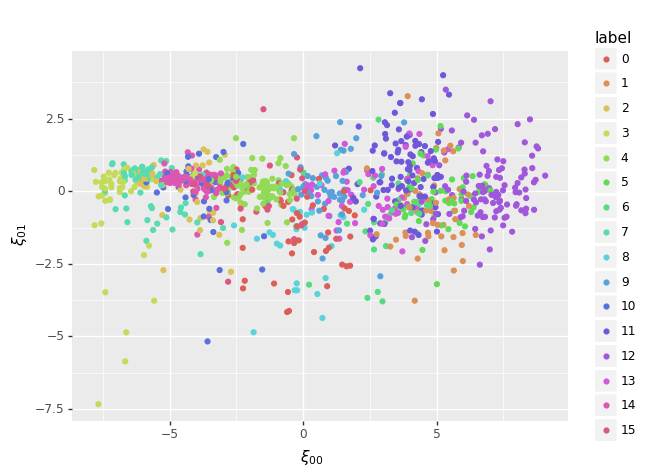

<ggplot: (320522998)>

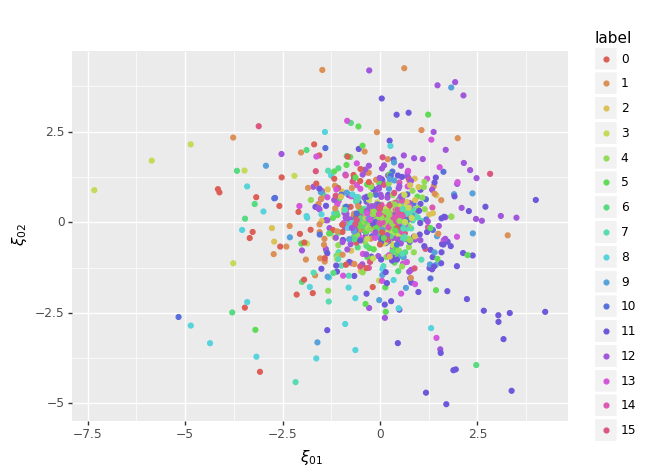

<ggplot: (-9223372036534517795)>

In [23]:
tmp = XI.sample(1000).assign(label = lambda df: df['label'].astype('category'))
p = ggplot(tmp)
p = p + geom_point(aes(x = 'xi00', y = 'xi01', color = 'label'))
p = p + scale_x_continuous(name = r'$\xi_{00}$')
p = p + scale_y_continuous(name = r'$\xi_{01}$')
display(p)
p = ggplot(tmp)
p = p + geom_point(aes(x = 'xi01', y = 'xi02', color = 'label'))
p = p + scale_x_continuous(name = r'$\xi_{01}$')
p = p + scale_y_continuous(name = r'$\xi_{02}$')
display(p)

### Projection directions as discriminative images

Let us first extract the matrix $\boldsymbol{\mathrm W}_{LDA}$ of orthogonal discriminative directions. Note that these are used to compute LDA projections

\begin{align*}
\boldsymbol{\xi} = \boldsymbol{\mathrm W}_{LDA} (\boldsymbol{x}_i-\boldsymbol{\mu})\,.
\end{align*}

The corresponding fields of the LDA object are `LDA.scalings_` and `LDA.xbar_`.
Note that class predictions can be computed through comparing score functions which can be expressed as

\begin{align*}
\boldsymbol{d} = \boldsymbol{\mathrm S}_{LDA}\boldsymbol{x} + \boldsymbol{s}_0
\end{align*}

where fields of the LDA object are `LDA.coef_` and `LDA.xbar_`. The point $\boldsymbol{x}$ gets prediction $i$ that maximises $d_i$.


In [24]:
W_LDA = DataFrame(lda.scalings_, 
                  index = ['x{:02d}'.format(i+1) for i in range((2*d+1)**2)],
                  columns = ['xi{:02d}'.format(i) for i in range(15)]).T
head(W_LDA)

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10,...,x216,x217,x218,x219,x220,x221,x222,x223,x224,x225
xi00,1.400554,-2.887215,4.025773,-2.074831,-2.045944,2.963200,-1.704709,0.207824,-0.484102,1.045903,...,-0.686658,0.540897,0.507629,-0.234228,1.017713,-1.007018,-0.041450,-0.091506,0.001538,0.057848
xi01,-0.647326,-0.635730,1.928939,-0.098900,-1.086619,-1.122167,-0.485562,0.430241,-0.082767,0.104162,...,4.014376,-3.069597,2.174789,-0.541041,2.505260,-5.841361,4.698516,-3.784109,2.156400,1.585117
xi02,3.545425,-3.957256,1.231499,5.040135,-2.186277,1.781789,-6.165414,3.773654,0.083836,0.885682,...,-2.931276,6.202134,-6.034677,0.460488,-1.175783,2.733239,0.409900,1.528803,3.418244,-4.331363
xi03,-5.253413,-0.329947,4.643795,-2.696030,2.544318,-3.417913,-4.480672,8.321236,-5.316589,4.078495,...,-0.681375,2.748007,-2.963725,-0.807435,1.196470,-0.827486,0.083179,0.576403,-3.988076,1.525940
xi04,-3.789360,7.136887,-7.600230,7.594701,-4.487375,-2.413910,7.344736,-10.431008,4.927288,1.523602,...,6.241318,-2.276001,3.699243,-5.902951,6.727482,-4.777606,0.232475,2.658042,-6.357122,4.611134


In [25]:
S_LDA = DataFrame(lda.coef_, 
                  columns = ['x{:02d}'.format(i+1) for i in range((2*d+1)**2)], 
                  index = ['f{:02d}'.format(i) for i in range(16)])
S_LDA

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10,...,x216,x217,x218,x219,x220,x221,x222,x223,x224,x225
f00,3.192742,-1.178272,-3.312308,-1.177610,1.500681,4.636880,3.029468,-6.245208,3.168619,-5.469717,...,-12.126976,11.280155,-8.942584,6.301472,-5.353109,8.156732,-6.362672,6.262029,-4.617416,-0.348574
f01,1.148543,-9.263282,13.512132,-2.299362,-12.854667,12.068014,-6.727075,-3.275263,0.163276,8.984323,...,-0.819841,5.683566,1.167219,-6.571228,10.943741,-6.737768,-1.882966,4.192720,-9.865175,5.420348
f02,-5.222700,13.360355,-20.863023,11.018802,9.573000,-9.310439,2.462639,-0.788551,2.827400,-7.199240,...,2.944696,-4.903195,-2.745005,1.671365,-8.469168,10.267339,-4.250503,2.419560,0.460190,0.559836
f03,-13.097400,19.546232,-29.077189,15.162718,18.944318,-24.671593,9.973185,0.740344,3.153937,-5.671169,...,6.600626,-5.086768,-3.424187,3.197265,-7.036086,3.796777,5.707447,-2.049120,-0.873220,-1.880647
f04,-2.676767,5.506682,-8.242743,6.097144,0.209079,-3.807583,3.581855,-0.505835,1.893681,-1.917403,...,2.639867,-1.899832,0.192672,0.142495,-0.472563,1.777487,-2.522761,2.845874,-0.958911,0.453764
f05,8.177917,-13.697580,28.270747,-17.535970,-4.024400,10.461107,-13.486760,12.514041,-13.572570,10.300584,...,-2.507153,6.024053,-3.109109,-0.948636,2.294996,-2.570444,-0.416747,1.883542,2.455831,-4.916088
f06,-2.123215,-12.516926,15.072546,-11.607885,-0.088461,7.460000,-8.926011,8.920633,-3.649951,0.368872,...,-12.097482,7.682653,-4.062509,3.870027,-4.864718,9.518655,-8.682055,1.487765,-2.654816,-0.256571
f07,-6.272462,17.658041,-24.124768,13.630391,12.095608,-16.228820,7.729287,0.174993,0.470620,-5.942273,...,8.992066,-5.796722,0.569697,-3.873071,-4.835127,4.121914,3.112998,-2.999082,0.402423,0.855617
f08,2.159293,10.238948,-9.787609,-0.240003,1.552268,-1.044812,9.234825,-5.903366,0.354370,3.517696,...,8.296758,-14.515544,13.714456,-6.577806,-1.322045,7.257892,-8.528837,3.390888,0.500413,-2.331468
f09,6.040238,-11.505704,11.666236,-7.443654,1.929551,5.073514,-10.826320,7.348268,-3.151568,2.578623,...,3.182464,-3.165711,1.665343,-0.263601,2.429736,-7.852328,8.271302,-5.395843,1.523372,-1.041184


Reshape back to texture masks in order to see what texture features are used to compute coordinates $\boldsymbol{\xi}$. 

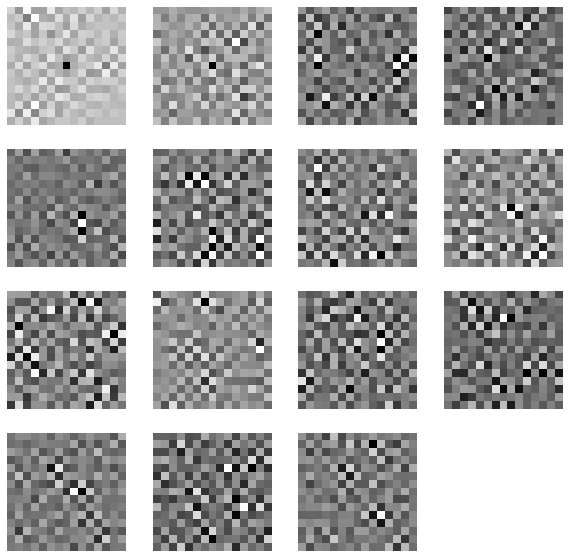

In [26]:
fig=plt.figure(figsize=(10,10))
for i in range(len(W_LDA)):
    fig.add_subplot(4, 4, i + 1)
    plt.axis('off')
    plt.imshow(W_LDA.iloc[i, :].values.reshape(2 * d + 1, 2 * d + 1), cmap = 'gray')

From this image it is clear that for most directions the pixel intensity of the original pixel has the largest impact.

### Scoring functions as  canonical texture shapes for individual classes

The scoring vectors show what are the characteristic convolution filters for different classes, i.e., what kind of shapes do we seek to label textures into classes. 

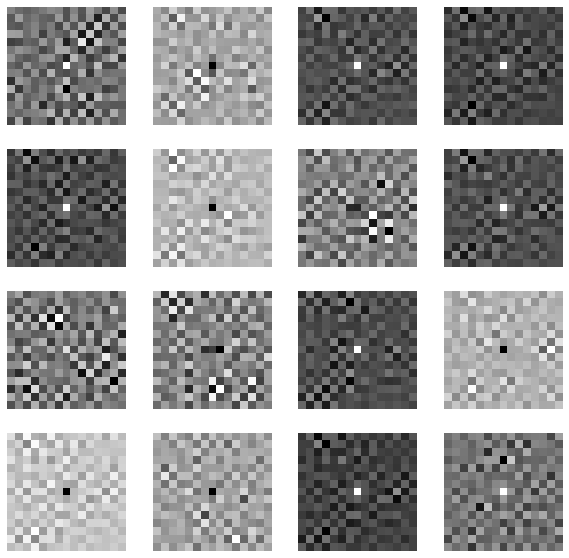

In [27]:
fig=plt.figure(figsize=(10,10))
for i in range(len(S_LDA)):
    fig.add_subplot(4, 4, i + 1)
    plt.axis('off')
    plt.imshow(S_LDA.iloc[i, :].values.reshape(2 * d + 1, 2 * d + 1), cmap = 'gray')

Again the shapes are dominated by a single center for most classes.

### How much do LDA directions fluctuate

* We can obviously ask what is the variance of individual projection directions $\xi_i$. 
* The corresponding theoretical estimates are captured by the `LDA.explained_variance_ratio_` field of the LDA object. 
* This shows only how the variance is distributed between $\boldsymbol{\xi}$ coordinates and not how much data variance it captures.
* This does not capture how much the entire LDA projection captures from the total data variance.

In [28]:
mdisplay([DataFrame(100 * lda.explained_variance_ratio_, 
                    columns = ['%'], 
                    index=['xi{:02d}'.format(i) for i in range(15)]).T],
         ['How variance is distributed'])

How variance is distributed 
 
 
 xi00 
 xi01 
 xi02 
 xi03 
 xi04 
 xi05 
 xi06 
 xi07 
 xi08 
 xi09 
 xi10 
 xi11 
 xi12 
 xi13 
 xi14 
 
 
 
 
 95.152392 
 1.326464 
 0.584297 
 0.523973 
 0.463527 
 0.405246 
 0.294949 
 0.263752 
 0.250323 
 0.199257 
 0.158026 
 0.127198 
 0.116444 
 0.090593 
 0.043559

### Variation covered by the projection vector of linear discriminant analysis

In [29]:
from scipy.linalg import orth

In [30]:
P_LDA = DataFrame(orth(W_LDA.T), 
                  index = ['x{:02d}'.format(i+1) for i in range((2*d+1)**2)], 
                  columns = ['w{:02d}'.format(i) for i in range(15)]).T
head(P_LDA)

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10,...,x216,x217,x218,x219,x220,x221,x222,x223,x224,x225
w00,0.048147,-0.003711,-0.044349,0.021200,0.006024,0.020005,-0.042845,-0.009749,0.040620,0.024365,...,0.053802,-0.043875,0.003812,0.047156,-0.005729,-0.015351,-0.010168,0.020714,-0.015747,0.038033
w01,0.016964,-0.013764,-0.016108,0.055185,-0.052471,0.031159,-0.050327,0.074453,-0.000086,0.022075,...,-0.037077,0.007629,0.003218,0.022476,-0.005582,0.010415,-0.015464,-0.002456,0.033580,-0.010650
w02,0.085719,-0.058287,-0.000390,-0.036708,0.057756,-0.013679,-0.026206,0.023470,-0.016108,0.055316,...,0.004991,0.026048,-0.024922,0.048061,0.009500,-0.075142,0.121862,-0.097529,0.067798,-0.007640
w03,0.004665,-0.042697,-0.002574,0.007474,-0.029026,0.056808,-0.027104,-0.032502,0.068016,-0.052302,...,-0.138902,0.145040,-0.132573,0.102433,-0.058250,0.099062,-0.115432,0.083587,-0.067779,0.059838
w04,-0.028787,0.048267,-0.073477,0.066273,-0.075086,0.036361,0.058487,-0.086939,0.040416,-0.025364,...,-0.021585,-0.043955,0.074008,-0.049508,0.068283,-0.088522,0.060138,-0.052559,-0.008032,0.044238


Let's compute an orthogonal projection to the linear space specified by LDA vectors. This will show how much variance LDA components can explain.

In [31]:
proj_LDA = P_LDA.T.dot(P_LDA.dot(df.iloc[:, 3:].T)).T
proj_other = df.iloc[:, 3:] - proj_LDA
head(proj_LDA)

,x01,x02,x03,x04,x05,x06,x07,x08,x09,x10,...,x216,x217,x218,x219,x220,x221,x222,x223,x224,x225
0,-0.006788,0.008072,-0.023480,0.013852,0.009686,-0.024286,0.018427,-0.009937,0.013907,-0.002312,...,0.014752,-0.001988,-0.003621,0.007094,-0.000022,-0.000517,0.003522,-0.000914,0.003322,0.000885
1,-0.009274,0.023204,-0.053889,0.019151,0.037351,-0.049864,0.028625,-0.007262,0.016054,-0.007958,...,0.021745,-0.012125,-0.007508,0.020722,-0.015086,0.007427,0.011241,-0.010479,0.017979,-0.004258
2,-0.013390,0.023920,-0.043687,0.017666,0.027492,-0.039749,0.024221,-0.003758,0.010036,-0.007647,...,0.015407,-0.006864,-0.005476,0.013148,-0.008678,0.001730,0.008630,-0.005662,0.003998,0.001345
3,-0.016813,0.032399,-0.067176,0.026614,0.040156,-0.057249,0.034365,-0.005995,0.016327,-0.010007,...,0.024987,-0.013671,-0.006921,0.022344,-0.013575,0.003582,0.013187,-0.010990,0.013065,0.001020
4,-0.012288,0.017541,-0.029234,0.007919,0.013407,-0.028395,0.025937,-0.007091,0.006303,-0.001838,...,0.012734,-0.013999,0.005013,0.009486,-0.000065,-0.005790,0.009396,-0.009414,0.013180,-0.000560


In [32]:
lda_var = np.var(proj_LDA).sum()
remaining_var = np.var(proj_other).sum()
total_var = np.var(df.iloc[:, 3:]).sum()

print('LDA variance:         {:.2f}%'.format(lda_var/total_var*100))
print('Unexplained variance {:.2f}%'.format(remaining_var/total_var*100))

LDA variance:         0.24%
Unexplained variance 99.76%


* The result clearly shows that LDA uses completely different directions than PCA and in fact most of the variance remains unexplained. 
* Thus subtle changes in the textures can lead to completely different LDA projections.

LDA chooses a projection that does not cover a lot of variance but this does not show how subtle clues LDA uses. The following visualisation shows the entire texture versus the subspace that determines all LDA coordinates $\boldsymbol{\xi}$. In this figure we show 10 random images and the corresponding LDA projection on the same scale as the original image and the normalised. Note that we cannot distinguish any textual features on the rescaled image except for the colour of the center pixel.     

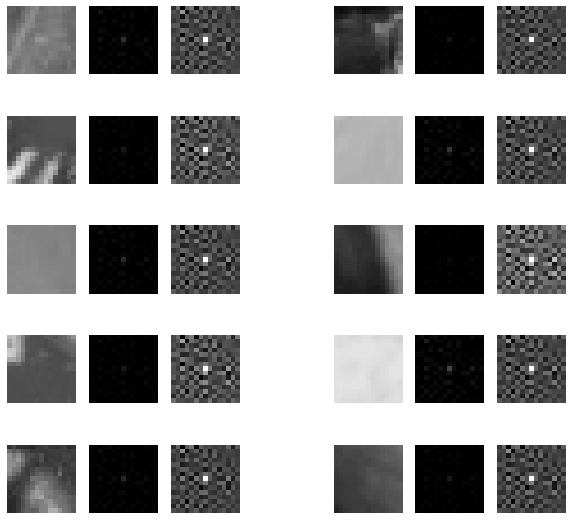

In [33]:
sdf = df.sample(10)
rdf = P_LDA.T.dot(P_LDA.dot(sdf.iloc[:, 3:].T)).T


fig=plt.figure(figsize=(10,40))
for i in range(int(len(sdf)/2)):
    fig.add_subplot(20, 7, 7 * i + 1)
    plt.axis('off')
    plt.imshow(sdf.iloc[2 * i, 3:].values.reshape(2 * d + 1, 2 * d + 1), vmin=0, vmax=1, cmap = 'gray')
    fig.add_subplot(20, 7, 7 * i + 2)
    plt.imshow(rdf.iloc[2 * i, :].values.reshape(2 * d + 1, 2 * d + 1), vmin=0, vmax=1, cmap = 'gray')
    plt.axis('off')
    fig.add_subplot(20, 7, 7 * i + 3)
    plt.imshow(rdf.iloc[2 * i, :].values.reshape(2 * d + 1, 2 * d + 1), cmap = 'gray')
    plt.axis('off')

    fig.add_subplot(20, 7, 7 * i + 5)
    plt.axis('off')
    plt.imshow(sdf.iloc[2 * i + 1, 3:].values.reshape(2 * d + 1, 2 * d + 1), vmin=0, vmax=1, cmap = 'gray')
    fig.add_subplot(20, 7, 7 * i + 6)
    plt.imshow(rdf.iloc[2 * i + 1, :].values.reshape(2 * d + 1, 2 * d + 1), vmin=0, vmax=1, cmap = 'gray')
    plt.axis('off')
    fig.add_subplot(20, 7, 7 * i + 7)
    plt.imshow(rdf.iloc[2 * i + 1, :].values.reshape(2 * d + 1, 2 * d + 1), cmap = 'gray')
    plt.axis('off')    

Formal verification that the LDA projection is correct. The result should be zero in theory but near-zero in practice.

In [34]:
lda.transform(sdf.iloc[:,3:])-lda.transform(rdf)

array([[ 2.55351296e-15, -5.88418203e-15,  4.44089210e-15,
         1.77635684e-15, -1.23234756e-14,  1.79301018e-14,
        -4.21884749e-15, -8.32667268e-15,  8.21565038e-15,
         7.21644966e-15, -8.88178420e-15, -2.10942375e-14,
        -1.55431223e-15,  3.66373598e-15, -1.11022302e-14],
       [-1.15463195e-14, -3.55271368e-15, -4.21884749e-15,
        -1.77635684e-15,  1.33226763e-15, -1.55431223e-15,
        -1.76525461e-14,  2.10942375e-15,  7.32747196e-15,
         4.44089210e-15, -1.54876112e-14,  1.66533454e-16,
         2.66453526e-15,  3.27515792e-15, -5.77315973e-15],
       [-9.76996262e-15,  2.10942375e-15,  1.64313008e-14,
         2.96984659e-15, -2.17603713e-14,  8.43769499e-15,
        -6.66133815e-15,  6.66133815e-15,  9.32587341e-15,
        -1.04360964e-14, -1.70974346e-14, -2.35367281e-14,
         9.32587341e-15,  8.60422844e-15,  9.38138456e-15],
       [-1.59872116e-14,  5.44009282e-15,  1.05471187e-14,
         1.63757896e-14, -2.63122857e-14,  7.21644966

# Homework

## 5.1  Predictive power of LDA projection (<font color='red'>2p</font>)  

Use `LDA.predict` function to predict class labels from texture vectors $\boldsymbol{x}_i$. Compute the corresponding confusion matrix and accuracy. How much is this result better than random? Predict class labels directly from LDA coordinates $\boldsymbol{\xi}$ by assigning the class which is closest to the class centers $(\bar{\boldsymbol{\xi}}_j)_{j=1}^{16}$. 

In [35]:
np.mean(lda.predict(df.iloc[:, 3:]) == df['label'])*100

63.660000000000004

## 5.2. Visual interpretation of LDA directions  (<font color='red'>2p</font>) 

Compute LDA coordinates $\boldsymbol{\xi}$ for reasonably sized subimages (e.g., $100\times 100$). Try to capture different textures and fruits.
You can use [`numpy.meshgrid`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) function to generate $(x,y)$ coordinates for the entire subimage. Use the existing LDA model to compute LDA coordinates for each pixel and add `luma` column. Now you have something that looks like a luma-chroma color space, except you have more dimensions. You can use some of these as substitutes for rRGB coordinates and thus you can use rgb reconstruction together with image reconstruction to see how LDA coordinates are spatially assigned and for which textures they are triggered.    

**Extra point:** Use LDA predictions to recover the color instead of true labels. Interpret results (<font color='red'>**1p**</font>).  

## 5.3 More appropriate texture generation  (<font color='red'>3p</font>) 

The main problem with our approach was very strong dependence on exact pixel intensities. The aim of this exercise is to remove the pixel intensity information. For that you need to center all textures $\boldsymbol{(x_{ij})}_{i,j=0}^{2d}$ so that the mean value $x_{00}+\ldots+x_{2d2d}=0$. 
Secondly, you can compute the average standard deviation of all coordinates

\begin{align*}
\sigma=\sqrt{\frac{\mathbf{Var}[x_{00}]+\cdots+\mathbf{Var}[x_{2d2d}]}{(2d+1)^2}}
\end{align*}

and scale the textures so that $\sigma=1$. As a result, you have effectively removed all information about the actual pixel intensities and the resulting vectors describe the textures in terms of intensity variation. Apply the entire analysis pipeline to get new LDA coordinates $\boldsymbol{\eta}$.
Visualise class separation across different directions and corresponding LDA texture masks.

**Extra points:**
* Estimate prediction precision from textures and from textures together with the pixel intensity. As usual, map to the closest cluster. (<font 
color='red'>**1p**</font>) 
* Use LDA predictions to recover the color instead of true labels. Interpret results. (<font color='red'>**1p**</font>) 
* Visualise projection coordinates $\boldsymbol{\eta}$ through RGB channels as in Exercise 5.2. (<font color='red'>**1p**</font>)

## 5.4 Targeted separation directions*  (<font color='red'>1p</font>) 

Define separating directions for a subset of clusters. Pick cluster pairs that have clearly different textures and see if the corresponding LDA shape encodes textual patterns you would expect. You need to use texture vectors that do not contain intensity information to get sensible results. 